In [6]:
#Import Libraries

In [23]:
import pandas as pd
import re
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from os import listdir
import os
from os.path import isfile, join

DATADIR = 'stock_files'
GRAPHDIR = 'stock_graphs'

In [8]:
#Define Functions

In [39]:
def enrich_stock_with_smas(stock_pd):
    stock_pd["SMA2"] = stock_pd['Close'].rolling(window=2).mean()
    stock_pd["SMA5"] = stock_pd['Close'].rolling(window=5).mean()
    stock_pd["SMA10"] = stock_pd['Close'].rolling(window=10).mean()
    stock_pd["SMA25"] = stock_pd['Close'].rolling(window=25).mean()
    stock_pd["SMA50"] = stock_pd['Close'].rolling(window=50).mean()
    stock_pd["SMA90"] = stock_pd['Close'].rolling(window=90).mean()
    stock_pd["SMA120"] = stock_pd['Close'].rolling(window=120).mean()
    stock_pd["SMA180"] = stock_pd['Close'].rolling(window=180).mean()
    e_stock_pd = stock_pd
    return e_stock_pd

def enrich_stock_with_bbs(stock_pd):
    #Bollinger Bands
    stock_pd['EWMA'] = stock_pd['Close'].ewm(halflife=0.5, min_periods=20).mean()
    stock_pd['middle_band'] = stock_pd['Close'].rolling(window=20).mean()
    stock_pd['upper_band'] = stock_pd['Close'].rolling(window=20).mean() + stock_pd['Close'].rolling(window=20).std()*2
    stock_pd['lower_band'] = stock_pd['Close'].rolling(window=20).mean() - stock_pd['Close'].rolling(window=20).std()*2
    e_stock_pd = stock_pd
    return e_stock_pd

def print_sma_chart_days(stock_ticker, stock_pd, nDays):
    dt_latest = stock_pd.iloc[-1:].index[0]
    if isinstance(dt_latest, str):
        dt_latest = datetime.strptime(dt_latest,"%Y-%m-%d")
    dt_previous = dt_latest - timedelta(days=nDays)
    plt.figure(figsize=(12,10))
    plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    plt.plot(stock_pd['Close'], label="Close")
    plt.title("["+stock_ticker+"] "+"Stock Price with SMAs from ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"] | ["+str(nDays)+"] Days")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous, dt_latest])
    plt.legend()
    
    stock_graph_name = stock_ticker+"_"+str(nDays)+"_"+dt_previous.strftime("%Y-%m-%d")+"_"+dt_latest.strftime("%Y-%m-%d")
    dt_str_latest_date = dt_latest.strftime("%Y-%m-%d")
    path_ts = os.path.join(GRAPHDIR,dt_str_latest_date)
    
    try:
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
        plt.savefig(path_ts+r'/'+stock_graph_name+r'.png')
        print("Saved Plot as: ["+path_ts+r'/'+stock_graph_name+".png]")
    except:
        print("Error! Could not save Plot as: ["+path_ts+r'/'+stock_graph_name+".png]")
    plt.show()

def last_stock_date(stock_pd):
    return stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    
def first_stock_date(stock_pd):
    return stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")

def save_dataframe_as_csv(stock_pd,stock_ticker):
    dt_str_first_date = stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")
    dt_str_latest_date = stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    stock_file_name = stock_ticker+"_"+dt_str_first_date+"_"+dt_str_latest_date+".csv"
    try:
        path_ts = os.path.join(DATADIR,dt_str_latest_date)
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
        stock_pd.to_csv(path_ts+r'/'+stock_file_name)
        print("Saved DataFrame as: ["+path_ts+r'/'+stock_file_name+"]")
    except:
        print("Error! Could not save Dataframe as: ["+path_ts+r'/'+stock_file_name+"]")

def convert_df_to_pd(stock_df):
    stock_pd = pd.DataFrame(stock_df)
    return stock_pd

def online_process_stock_once(stock_ticker,nDays):
    stock_df = yf.download(stock_ticker)
    stock_pd = convert_df_to_pd(stock_df)
    stock_pd = enrich_stock_with_smas(stock_pd)
    stock_pd = enrich_stock_with_bbs(stock_pd)
    save_dataframe_as_csv(stock_pd,stock_ticker)
    #print(stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,nDays)

def get_list_of_files_in_dir(dir_name):
    list_of_files_only = [f for f in listdir(dir_name) if isfile(join(dir_name, f))]
    return list_of_files_only

def read_offline_csv_to_dataframe(dir_name,file_name):
    read_stock_pd = pd.read_csv(DATADIR+r'/'+file_name)
    read_stock_pd['Date'] = pd.to_datetime(read_stock_pd['Date'])
    read_stock_pd.set_index('Date', inplace=True)
    return read_stock_pd

def get_stock_ticker_name_from_file_name(file_name):
    m = re.search('(^[a-zA-Z]+?)_', file_name)
    if m:
        found = m.group(1)
    return found

def get_stock_dataframe_from_local(dir_name,stock_ticker):
    stock_pd = pd.DataFrame()
    list_of_files = get_list_of_files_in_dir(dir_name)
    for file_name in list_of_files:
        current_stock_title = get_stock_ticker_name_from_file_name(file_name)
        if stock_ticker == current_stock_title:
            stock_pd = read_offline_csv_to_dataframe(dir_name,file_name)
            break
    return stock_pd

def offline_process_stock_once(dir_name,stock_ticker,nDays):
    stock_pd = get_stock_dataframe_from_local(dir_name,stock_ticker)
    print(stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,nDays)

In [30]:
### RUN ONLINE UNIT TEST

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/TSLA_2010-06-29_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/TSLA_120_2020-03-04_2020-07-02.png]


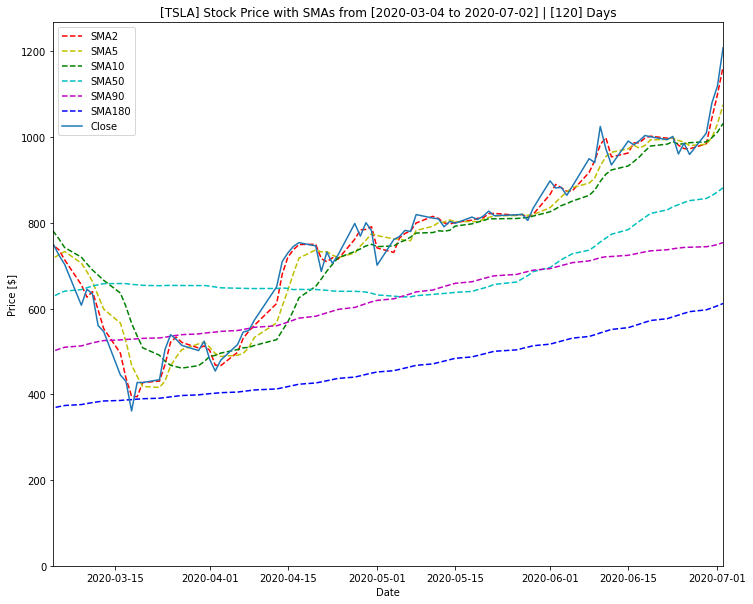

In [40]:
tickers_to_iterate = ['TSLA']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name,120)

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/TSLA_2010-06-29_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/TSLA_120_2020-03-04_2020-07-02.png]


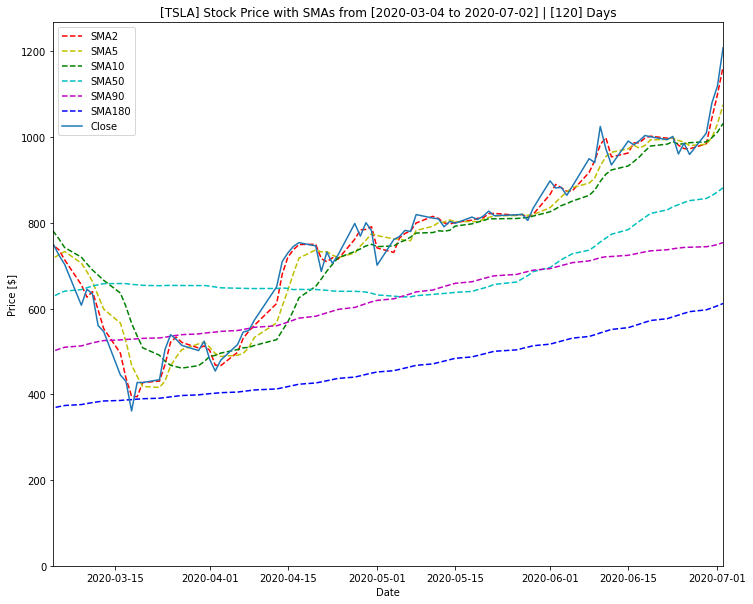

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/GOOG_2004-08-19_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/GOOG_120_2020-03-04_2020-07-02.png]


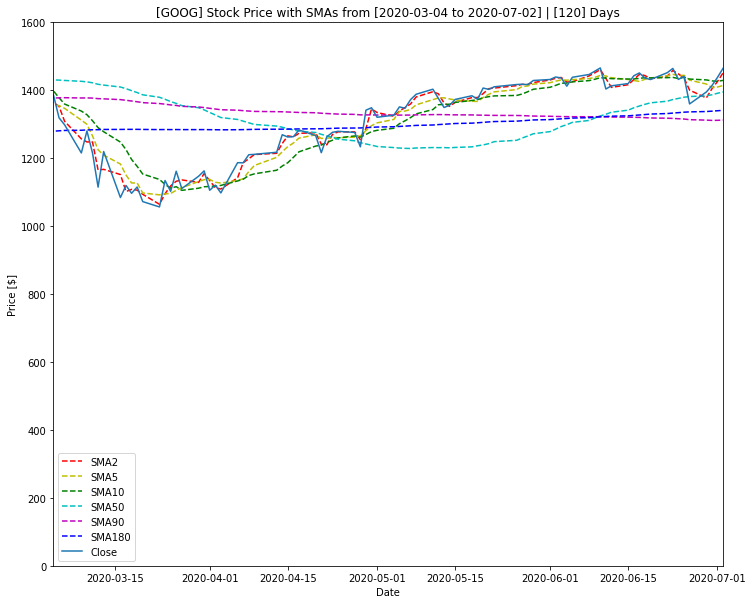

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/AMZN_1997-05-15_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/AMZN_120_2020-03-04_2020-07-02.png]


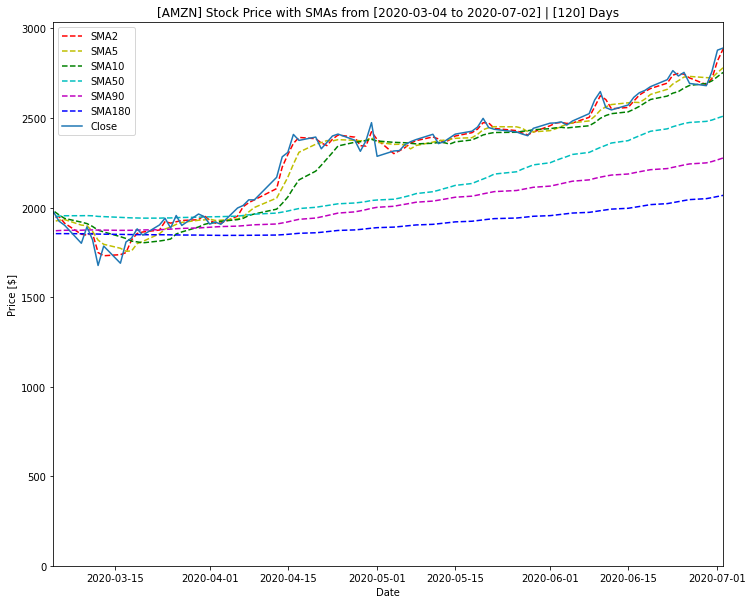

[*********************100%***********************]  1 of 1 completed

In [ ]:
### PRODUCTION EXPERIMENTATION
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name,120)

In [ ]:
### PRODUCTION OFFLINE EXPERIMENTATION
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    offline_process_stock_once(DATADIR,ticker_name)